# Import

In [1]:
# pip install giotto-tda
from gtda.homology import EuclideanCechPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.pipeline import Pipeline
from gtda.diagrams import Filtering

import numpy as np              # pip install numpy
import matplotlib.pyplot as plt # pip install matplotlib
from rdkit import Chem          # pip install rdkit-pypi
from rich import print          # pip install rich
import pandas as pd             # pip install pandas
from colour import Color        # pip install colour

from random import choice, sample
import json

# Load the MS data
Here I'm only using 500 molecules as an example

In [2]:
with open("SMILES/CFMID4.0/Drugbank2019_MS_CFMID4.0.json", mode = "r") as _f:
    db = json.load(_f)
mol_strings = sample(list(db.keys()), 500)
data = { mol : db[mol] for mol in mol_strings }
print(data[choice(mol_strings)])
del db

{
    'energy0': {
        'mz': [
            121.02841,
            145.02841,
            163.03897,
            181.04954,
            291.08631,
            293.10196,
            309.09688,
            337.09179,
            355.10236
        ],
        'intens': [5.15, 10.96, 100.0, 24.83, 5.33, 5.87, 7.27, 17.89, 7.02]
    },
    'energy1': {
        'mz': [
            73.02841,
            109.02841,
            117.03349,
            119.04914,
            121.02841,
            123.04406,
            135.04406,
            145.02841,
            151.03897,
            153.05462,
            163.03897,
            181.04954
        ],
        'intens': [7.4, 3.57, 10.11, 3.15, 6.38, 3.34, 17.92, 8.1, 3.44, 2.45, 100.0, 5.59]
    },
    'energy2': {
        'mz': [
            43.01784,
            59.01276,
            77.03858,
            91.01784,
            93.03349,
            95.04914,
            101.02332,
            103.03897,
            105.03349,
            107.04914,
            117.03349,
            119.04914,
            121.02841,
            123.04406,
            133.02841,
            135.04406,
            145.02841,
            147.04406,
            161.02332,
            163.03897,
            265.07066,
            267.04993,
            269.06558,
            279.04993,
            281.06558,
            285.09688,
            295.08123,
            297.09688,
            309.09688,
            313.09179
        ],
        'intens': [
            13.37,
            13.64,
            59.86,
            23.92,
            43.68,
            19.1,
            15.11,
            24.25,
            28.79,
            30.65,
            94.37,
            12.84,
            35.42,
            69.1,
            32.76,
            100.0,
            61.16,
            29.89,
            27.26,
            66.95,
            20.65,
            11.07,
            15.18,
            16.84,
            42.36,
            27.15,
            15.93,
            42.73,
            14.02,
            21.03
        ]
    }
}

# Transform data to point clouds

In [3]:
spectra = dict()

for m in mol_strings:
    energies = [
        np.asarray([ (np.floor(x), x - np.floor(x)) for x in data[m]["energy0"]["mz"] ]),
        np.asarray([ (np.floor(x), x - np.floor(x)) for x in data[m]["energy1"]["mz"] ]),
        np.asarray([ (np.floor(x), x - np.floor(x)) for x in data[m]["energy2"]["mz"] ])
    ]
    for i,energy in enumerate(energies):
        energies[i][:,0] = np.log(energy[:,0])/np.log(6000)
        
    spectra[m] = tuple(energies)

# Inspect point cloud

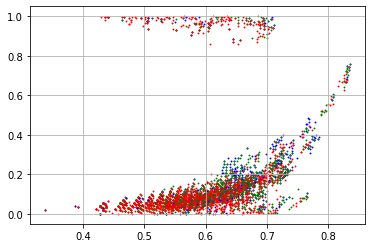

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
for m in mol_strings[:100]:
    (X0,X1,X2) = spectra[ m ]
    ax.scatter(X0[:,0],X0[:,1], color = "blue", s = 3, marker = ".")
    ax.scatter(X1[:,0],X1[:,1], color = "green", s = 3, marker = ".")
    ax.scatter(X2[:,0],X2[:,1], color = "red", s = 3, marker = ".")
    ax.grid("both")
plt.show()

# Compute Čech persistence
If you were training a model then you would need to call `compute_cech_persistence` for two different dictionaries. One for testing and one for training.

Remark: The plots will look a little different than the plots in the report. This is because here we have set `max_edge_length = np.sqrt(2)`. Specifying a max edge length gives a better $\delta\epsilon$.
To get plots which are similar to the report, set this to `max_edge_length = np.inf`, although then the $\delta \epsilon$ will be inferred by `giotto`.

Please read for more information:
https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.EuclideanCechPersistence.html#euclideancechpersistence

In [5]:
def compute_cech_persistence(spectra):
    pipeline = Pipeline([
        
        # compute persistence diagrams 
        ('diagram', EuclideanCechPersistence(
            homology_dimensions = [0,1,2],
            max_edge_length = np.sqrt(2), # give information about the size of the space
            #max_edge_length = np.inf, # let giotto find step size (report plots)
            n_jobs = 3,
        )),
        
        # remove noise
        ('filtering', Filtering()),
        
        # vectorize
        ('entropy', PersistenceEntropy()),
    ])
    
    # dictionary of 3-tuples of point clouds
    molecules = list(spectra.keys())
    x0 = [ spectra[m][0] for m in molecules ]
    x1 = [ spectra[m][1] for m in molecules ]
    x2 = [ spectra[m][2] for m in molecules ]
    
    data = (
        pipeline.fit_transform(x0),
        pipeline.fit_transform(x1),
        pipeline.fit_transform(x2),
    )
    data = np.concatenate(data, axis = 1)
    return molecules, data

molecules, data = compute_cech_persistence(spectra)

In [6]:
print(len(molecules))
print(data.shape)

500

(500, 9)

# Read descriptors data

In [7]:
df = pd.read_csv("SMILES/Drugbank_some_descriptors.csv")
descriptor = "OEselma Descriptors;aromatic_ring_count"
#descriptor = "Polarizability"
print(descriptor, "NaN values:", len([v for v in df[descriptor].isna() if v]))

OEselma Descriptors;aromatic_ring_count NaN values: 17

# Create color mapping

In [8]:
def make_monotone_map(dd):
    keys = sorted( list(dd))
    return { k : idx for idx,k in enumerate(keys) }

select = df[descriptor].dropna()
unq = pd.unique( select )
mm = make_monotone_map(unq)
values = select.map(mm)
print(values)

0        3
1        4
2        8
3        2
4        5
        ..
10627    4
10628    3
10629    0
10630    3
10631    3
Name: OEselma Descriptors;aromatic_ring_count, Length: 10615, dtype: int64

In [9]:
colors = list(map(
    Color.get_rgb,
    Color("blue").range_to(Color("red"), len(mm))
))
df_smiles = list(df["SMILES"])
idxs = np.asarray(
    [
        [i, idx]
        for i,m in enumerate(molecules) if (idx := df_smiles.index(m)) in values.index
    ]
)
print(idxs[:10])
features = data[idxs[:,0],:]
values = values[idxs[:,1]]
colormap = np.asarray([ colors[i] for i in values ])

[[   0 2656]
 [   1 2882]
 [   2 4950]
 [   3 4657]
 [   4 6854]
 [   5 5174]
 [   6 5355]
 [   7  536]
 [   8 9457]
 [   9 3155]]

# Plot

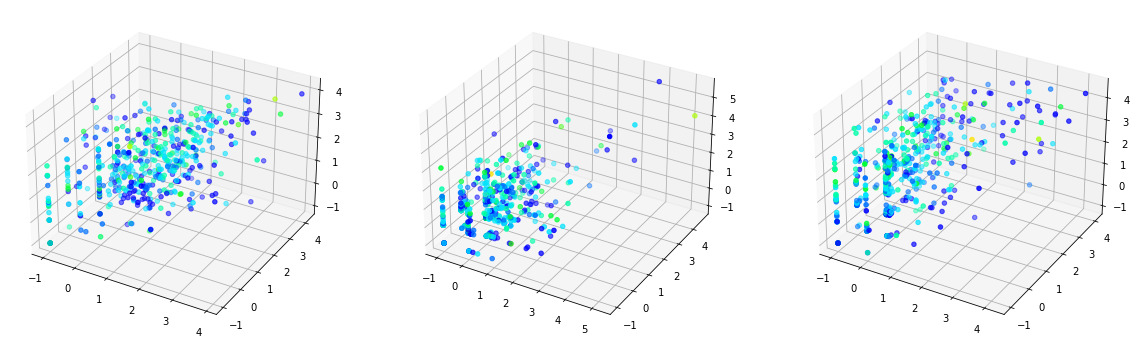

In [10]:
fig = plt.figure(figsize = (20,20))

# [:,index]  homology 0   homology 1    homology 2
# energy0:   0            1             2
# energy1:   3            4             5
# energy2:   6            7             8

ax = fig.add_subplot(131, projection='3d')
ax.scatter(features[:,0],features[:,3],features[:,6], c = colormap)

ax = fig.add_subplot(132, projection='3d')
ax.scatter(features[:,1],features[:,4],features[:,7], c = colormap)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(features[:,2],features[:,5],features[:,8], c = colormap)

plt.show()